In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=1)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=0, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=1, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

  1%|          | 1/100 [00:59<1:38:00, 59.40s/it]

{'regret_max': 0.3724735379219055, 'regret_mean': 0.009128068573772907, 'regret_mults': tensor([[5.4481]], device='cuda:0'), 'payment': 0.32485437393188477}


  2%|▏         | 2/100 [01:58<1:36:56, 59.36s/it]

{'regret_max': 0.023110568523406982, 'regret_mean': 0.0031907365191727877, 'regret_mults': tensor([[5.9965]], device='cuda:0'), 'payment': 0.37802693247795105}


  3%|▎         | 3/100 [02:57<1:35:54, 59.33s/it]

{'regret_max': 0.03086411952972412, 'regret_mean': 0.0028098816983401775, 'regret_mults': tensor([[7.6699]], device='cuda:0'), 'payment': 0.38224029541015625}


  4%|▍         | 4/100 [03:57<1:34:57, 59.35s/it]

{'regret_max': 0.030957520008087158, 'regret_mean': 0.0021988465450704098, 'regret_mults': tensor([[10.1959]], device='cuda:0'), 'payment': 0.3859115540981293}


  5%|▌         | 5/100 [04:56<1:33:55, 59.33s/it]

{'regret_max': 0.04295104742050171, 'regret_mean': 0.0022363755851984024, 'regret_mults': tensor([[11.1284]], device='cuda:0'), 'payment': 0.38380420207977295}


  6%|▌         | 6/100 [05:56<1:33:01, 59.37s/it]

{'regret_max': 0.011996269226074219, 'regret_mean': 0.0014668903313577175, 'regret_mults': tensor([[11.8123]], device='cuda:0'), 'payment': 0.38668984174728394}


  7%|▋         | 7/100 [06:55<1:31:58, 59.34s/it]

{'regret_max': 0.014066338539123535, 'regret_mean': 0.0013976473128423095, 'regret_mults': tensor([[13.2523]], device='cuda:0'), 'payment': 0.3855403661727905}


  8%|▊         | 8/100 [07:54<1:31:00, 59.35s/it]

{'regret_max': 0.014956295490264893, 'regret_mean': 0.0012535450514405966, 'regret_mults': tensor([[16.4217]], device='cuda:0'), 'payment': 0.38397425413131714}


  9%|▉         | 9/100 [08:53<1:29:58, 59.32s/it]

{'regret_max': 0.017416954040527344, 'regret_mean': 0.0011488792952150106, 'regret_mults': tensor([[17.7751]], device='cuda:0'), 'payment': 0.3824619650840759}


 10%|█         | 10/100 [09:53<1:28:59, 59.33s/it]

{'regret_max': 0.012809395790100098, 'regret_mean': 0.0009760611574165523, 'regret_mults': tensor([[18.6853]], device='cuda:0'), 'payment': 0.3818057179450989}


 11%|█         | 11/100 [10:52<1:27:57, 59.30s/it]

{'regret_max': 0.010723233222961426, 'regret_mean': 0.0008518232498317957, 'regret_mults': tensor([[21.1745]], device='cuda:0'), 'payment': 0.38116735219955444}


 12%|█▏        | 12/100 [11:51<1:26:54, 59.26s/it]

{'regret_max': 0.010042250156402588, 'regret_mean': 0.0008582124719396234, 'regret_mults': tensor([[22.7059]], device='cuda:0'), 'payment': 0.38051432371139526}


 13%|█▎        | 13/100 [12:50<1:25:55, 59.26s/it]

{'regret_max': 0.009707331657409668, 'regret_mean': 0.0007600975804962218, 'regret_mults': tensor([[24.1558]], device='cuda:0'), 'payment': 0.379860520362854}


 14%|█▍        | 14/100 [13:50<1:24:57, 59.28s/it]

{'regret_max': 0.008982479572296143, 'regret_mean': 0.0007359881419688463, 'regret_mults': tensor([[26.1902]], device='cuda:0'), 'payment': 0.37879717350006104}


 15%|█▌        | 15/100 [14:49<1:23:59, 59.29s/it]

{'regret_max': 0.008297383785247803, 'regret_mean': 0.0006991771515458822, 'regret_mults': tensor([[29.3487]], device='cuda:0'), 'payment': 0.3778485059738159}


 16%|█▌        | 16/100 [15:48<1:23:00, 59.29s/it]

{'regret_max': 0.008542299270629883, 'regret_mean': 0.000592680589761585, 'regret_mults': tensor([[30.3948]], device='cuda:0'), 'payment': 0.3770895004272461}


 17%|█▋        | 17/100 [16:48<1:21:59, 59.27s/it]

{'regret_max': 0.012124776840209961, 'regret_mean': 0.0005848071887157857, 'regret_mults': tensor([[31.7256]], device='cuda:0'), 'payment': 0.3767229914665222}


 18%|█▊        | 18/100 [17:47<1:20:58, 59.25s/it]

{'regret_max': 0.0070795416831970215, 'regret_mean': 0.00046879882575012743, 'regret_mults': tensor([[33.3749]], device='cuda:0'), 'payment': 0.3766375184059143}


 19%|█▉        | 19/100 [18:46<1:19:58, 59.25s/it]

{'regret_max': 0.007630825042724609, 'regret_mean': 0.0004913349403068423, 'regret_mults': tensor([[36.3958]], device='cuda:0'), 'payment': 0.37618696689605713}


 20%|██        | 20/100 [19:46<1:19:04, 59.31s/it]

{'regret_max': 0.0064370036125183105, 'regret_mean': 0.00043220800580456853, 'regret_mults': tensor([[37.5086]], device='cuda:0'), 'payment': 0.3754870593547821}


 21%|██        | 21/100 [20:45<1:18:01, 59.25s/it]

{'regret_max': 0.008595407009124756, 'regret_mean': 0.0004519302165135741, 'regret_mults': tensor([[38.4892]], device='cuda:0'), 'payment': 0.3747621774673462}


 22%|██▏       | 22/100 [21:44<1:17:01, 59.25s/it]

{'regret_max': 0.00706106424331665, 'regret_mean': 0.00037696139770559967, 'regret_mults': tensor([[40.0490]], device='cuda:0'), 'payment': 0.37481364607810974}


 23%|██▎       | 23/100 [22:43<1:16:00, 59.22s/it]

{'regret_max': 0.0051648616790771484, 'regret_mean': 0.0003327513986732811, 'regret_mults': tensor([[40.7142]], device='cuda:0'), 'payment': 0.3749696612358093}


 24%|██▍       | 24/100 [23:42<1:15:05, 59.28s/it]

{'regret_max': 0.006715595722198486, 'regret_mean': 0.0003680615918710828, 'regret_mults': tensor([[41.3107]], device='cuda:0'), 'payment': 0.3746570944786072}


 25%|██▌       | 25/100 [24:42<1:14:02, 59.23s/it]

{'regret_max': 0.006624341011047363, 'regret_mean': 0.00033968541538342834, 'regret_mults': tensor([[43.1342]], device='cuda:0'), 'payment': 0.37457576394081116}


 26%|██▌       | 26/100 [25:41<1:13:00, 59.20s/it]

{'regret_max': 0.0055699944496154785, 'regret_mean': 0.00027010045596398413, 'regret_mults': tensor([[44.1707]], device='cuda:0'), 'payment': 0.3747657835483551}


 27%|██▋       | 27/100 [26:40<1:12:03, 59.22s/it]

{'regret_max': 0.004796922206878662, 'regret_mean': 0.00028752273647114635, 'regret_mults': tensor([[45.2057]], device='cuda:0'), 'payment': 0.37467753887176514}


 28%|██▊       | 28/100 [27:39<1:11:04, 59.23s/it]

{'regret_max': 0.008395075798034668, 'regret_mean': 0.0002752035215962678, 'regret_mults': tensor([[45.8660]], device='cuda:0'), 'payment': 0.37431859970092773}


 29%|██▉       | 29/100 [28:38<1:10:05, 59.23s/it]

{'regret_max': 0.004436969757080078, 'regret_mean': 0.00024411526101175696, 'regret_mults': tensor([[47.4574]], device='cuda:0'), 'payment': 0.3739369511604309}


 30%|███       | 30/100 [29:38<1:09:10, 59.30s/it]

{'regret_max': 0.0049746036529541016, 'regret_mean': 0.00024994707200676203, 'regret_mults': tensor([[48.5284]], device='cuda:0'), 'payment': 0.3741699457168579}


 31%|███       | 31/100 [30:37<1:08:10, 59.28s/it]

{'regret_max': 0.0058310627937316895, 'regret_mean': 0.000274642399745062, 'regret_mults': tensor([[49.3736]], device='cuda:0'), 'payment': 0.3736386299133301}


 32%|███▏      | 32/100 [31:36<1:07:11, 59.29s/it]

{'regret_max': 0.005202829837799072, 'regret_mean': 0.00022932518913876265, 'regret_mults': tensor([[50.3741]], device='cuda:0'), 'payment': 0.37386953830718994}


 33%|███▎      | 33/100 [32:36<1:06:19, 59.40s/it]

{'regret_max': 0.00552445650100708, 'regret_mean': 0.00023990935005713254, 'regret_mults': tensor([[53.2865]], device='cuda:0'), 'payment': 0.37356650829315186}


 34%|███▍      | 34/100 [33:36<1:05:24, 59.47s/it]

{'regret_max': 0.005434870719909668, 'regret_mean': 0.00020132324425503612, 'regret_mults': tensor([[53.6936]], device='cuda:0'), 'payment': 0.3745778501033783}


 35%|███▌      | 35/100 [34:35<1:04:22, 59.42s/it]

{'regret_max': 0.004941761493682861, 'regret_mean': 0.00022159605578053743, 'regret_mults': tensor([[54.3197]], device='cuda:0'), 'payment': 0.3739197850227356}


 36%|███▌      | 36/100 [35:34<1:03:20, 59.38s/it]

{'regret_max': 0.006124317646026611, 'regret_mean': 0.0002178228460252285, 'regret_mults': tensor([[55.6347]], device='cuda:0'), 'payment': 0.3743565082550049}


 37%|███▋      | 37/100 [36:34<1:02:18, 59.34s/it]

{'regret_max': 0.005015969276428223, 'regret_mean': 0.0001997101935558021, 'regret_mults': tensor([[56.1444]], device='cuda:0'), 'payment': 0.3740680515766144}


 38%|███▊      | 38/100 [37:33<1:01:16, 59.30s/it]

{'regret_max': 0.006627082824707031, 'regret_mean': 0.00021573860431089997, 'regret_mults': tensor([[56.8822]], device='cuda:0'), 'payment': 0.3739113211631775}


 39%|███▉      | 39/100 [38:32<1:00:15, 59.27s/it]

{'regret_max': 0.006644070148468018, 'regret_mean': 0.00021521447342820466, 'regret_mults': tensor([[57.8342]], device='cuda:0'), 'payment': 0.3736303448677063}


 40%|████      | 40/100 [39:31<59:14, 59.25s/it]  

{'regret_max': 0.0031443238258361816, 'regret_mean': 0.0001440849300706759, 'regret_mults': tensor([[59.8930]], device='cuda:0'), 'payment': 0.37552976608276367}


 41%|████      | 41/100 [40:30<58:16, 59.26s/it]

{'regret_max': 0.004514455795288086, 'regret_mean': 0.00015800097025930882, 'regret_mults': tensor([[61.3082]], device='cuda:0'), 'payment': 0.37507787346839905}


 42%|████▏     | 42/100 [41:30<57:17, 59.27s/it]

{'regret_max': 0.007866322994232178, 'regret_mean': 0.00021758556249551475, 'regret_mults': tensor([[63.0792]], device='cuda:0'), 'payment': 0.3739795386791229}


 43%|████▎     | 43/100 [42:29<56:20, 59.31s/it]

{'regret_max': 0.005577802658081055, 'regret_mean': 0.0001779643789632246, 'regret_mults': tensor([[64.9751]], device='cuda:0'), 'payment': 0.3745383322238922}


 44%|████▍     | 44/100 [43:28<55:20, 59.29s/it]

{'regret_max': 0.0067716240882873535, 'regret_mean': 0.00016485262312926352, 'regret_mults': tensor([[65.7507]], device='cuda:0'), 'payment': 0.37433189153671265}


 45%|████▌     | 45/100 [44:28<54:20, 59.29s/it]

{'regret_max': 0.003484070301055908, 'regret_mean': 0.00013910967390984297, 'regret_mults': tensor([[66.2482]], device='cuda:0'), 'payment': 0.37457236647605896}


 46%|████▌     | 46/100 [45:27<53:21, 59.28s/it]

{'regret_max': 0.003268718719482422, 'regret_mean': 0.00013170084275770932, 'regret_mults': tensor([[66.8051]], device='cuda:0'), 'payment': 0.37565848231315613}


 47%|████▋     | 47/100 [46:26<52:23, 59.32s/it]

{'regret_max': 0.00350835919380188, 'regret_mean': 0.0001427134411642328, 'regret_mults': tensor([[67.9585]], device='cuda:0'), 'payment': 0.375402569770813}


 48%|████▊     | 48/100 [47:25<51:20, 59.25s/it]

{'regret_max': 0.006242632865905762, 'regret_mean': 0.00015728047583252192, 'regret_mults': tensor([[68.5249]], device='cuda:0'), 'payment': 0.37450361251831055}


 49%|████▉     | 49/100 [48:25<50:21, 59.25s/it]

{'regret_max': 0.0081978440284729, 'regret_mean': 0.00022593185713049024, 'regret_mults': tensor([[69.8716]], device='cuda:0'), 'payment': 0.3735846281051636}


 50%|█████     | 50/100 [49:24<49:21, 59.24s/it]

{'regret_max': 0.004430234432220459, 'regret_mean': 0.0001403915521223098, 'regret_mults': tensor([[71.9776]], device='cuda:0'), 'payment': 0.3743288516998291}


 51%|█████     | 51/100 [50:23<48:21, 59.22s/it]

{'regret_max': 0.005541980266571045, 'regret_mean': 0.00015889061614871025, 'regret_mults': tensor([[72.3445]], device='cuda:0'), 'payment': 0.3731823265552521}


 52%|█████▏    | 52/100 [51:22<47:22, 59.22s/it]

{'regret_max': 0.005003809928894043, 'regret_mean': 0.00011589583300519735, 'regret_mults': tensor([[73.1937]], device='cuda:0'), 'payment': 0.3749334216117859}


 53%|█████▎    | 53/100 [52:22<46:25, 59.28s/it]

{'regret_max': 0.004609167575836182, 'regret_mean': 0.0001265494793187827, 'regret_mults': tensor([[73.9082]], device='cuda:0'), 'payment': 0.37491095066070557}


 54%|█████▍    | 54/100 [53:21<45:26, 59.28s/it]

{'regret_max': 0.005151212215423584, 'regret_mean': 0.0001283094461541623, 'regret_mults': tensor([[75.3210]], device='cuda:0'), 'payment': 0.3745681047439575}


 55%|█████▌    | 55/100 [54:20<44:28, 59.29s/it]

{'regret_max': 0.004214644432067871, 'regret_mean': 0.00013334117829799652, 'regret_mults': tensor([[76.1740]], device='cuda:0'), 'payment': 0.37449610233306885}


 56%|█████▌    | 56/100 [55:20<43:28, 59.28s/it]

{'regret_max': 0.0033386945724487305, 'regret_mean': 0.00012707611313089728, 'regret_mults': tensor([[77.1245]], device='cuda:0'), 'payment': 0.3749356269836426}


 57%|█████▋    | 57/100 [56:19<42:27, 59.25s/it]

{'regret_max': 0.006495833396911621, 'regret_mean': 0.00014312042912933975, 'regret_mults': tensor([[78.5735]], device='cuda:0'), 'payment': 0.37416547536849976}


 58%|█████▊    | 58/100 [57:18<41:26, 59.21s/it]

{'regret_max': 0.00337141752243042, 'regret_mean': 0.00011866360728163272, 'regret_mults': tensor([[79.7494]], device='cuda:0'), 'payment': 0.3744615316390991}


 59%|█████▉    | 59/100 [58:17<40:28, 59.23s/it]

{'regret_max': 0.009211540222167969, 'regret_mean': 0.00014742107305210084, 'regret_mults': tensor([[80.5002]], device='cuda:0'), 'payment': 0.3738751709461212}


 60%|██████    | 60/100 [59:16<39:30, 59.26s/it]

{'regret_max': 0.004093647003173828, 'regret_mean': 0.00012360807158984244, 'regret_mults': tensor([[82.5566]], device='cuda:0'), 'payment': 0.3745180070400238}


 61%|██████    | 61/100 [1:00:16<38:31, 59.27s/it]

{'regret_max': 0.007239401340484619, 'regret_mean': 0.00015805459406692535, 'regret_mults': tensor([[84.4324]], device='cuda:0'), 'payment': 0.37374675273895264}


 62%|██████▏   | 62/100 [1:01:15<37:29, 59.20s/it]

{'regret_max': 0.003944456577301025, 'regret_mean': 0.00010558394569670781, 'regret_mults': tensor([[85.4307]], device='cuda:0'), 'payment': 0.37522584199905396}


 63%|██████▎   | 63/100 [1:02:14<36:29, 59.19s/it]

{'regret_max': 0.0038145780563354492, 'regret_mean': 0.00012056846753694117, 'regret_mults': tensor([[86.2414]], device='cuda:0'), 'payment': 0.3744535446166992}


 64%|██████▍   | 64/100 [1:03:13<35:30, 59.18s/it]

{'regret_max': 0.003980278968811035, 'regret_mean': 0.00012454221723601222, 'regret_mults': tensor([[86.8332]], device='cuda:0'), 'payment': 0.37368154525756836}


 65%|██████▌   | 65/100 [1:04:12<34:30, 59.16s/it]

{'regret_max': 0.0042882561683654785, 'regret_mean': 0.00010660004772944376, 'regret_mults': tensor([[87.5624]], device='cuda:0'), 'payment': 0.37490639090538025}


 66%|██████▌   | 66/100 [1:05:12<33:32, 59.19s/it]

{'regret_max': 0.003922164440155029, 'regret_mean': 9.562210470903665e-05, 'regret_mults': tensor([[88.3232]], device='cuda:0'), 'payment': 0.3752306401729584}


 67%|██████▋   | 67/100 [1:06:11<32:35, 59.24s/it]

{'regret_max': 0.004991412162780762, 'regret_mean': 0.00012377301754895598, 'regret_mults': tensor([[88.9711]], device='cuda:0'), 'payment': 0.3744460642337799}


 68%|██████▊   | 68/100 [1:07:10<31:35, 59.24s/it]

{'regret_max': 0.0038234591484069824, 'regret_mean': 0.00010331034718547016, 'regret_mults': tensor([[90.1175]], device='cuda:0'), 'payment': 0.37431973218917847}


 69%|██████▉   | 69/100 [1:08:09<30:37, 59.26s/it]

{'regret_max': 0.004464626312255859, 'regret_mean': 0.0001107966381823644, 'regret_mults': tensor([[90.6462]], device='cuda:0'), 'payment': 0.3745748698711395}


 70%|███████   | 70/100 [1:09:09<29:36, 59.23s/it]

{'regret_max': 0.00823301076889038, 'regret_mean': 0.00014041927352081984, 'regret_mults': tensor([[91.4361]], device='cuda:0'), 'payment': 0.37339916825294495}


 71%|███████   | 71/100 [1:10:08<28:37, 59.24s/it]

{'regret_max': 0.006026625633239746, 'regret_mean': 0.0001258277625311166, 'regret_mults': tensor([[91.8022]], device='cuda:0'), 'payment': 0.3745499551296234}


 72%|███████▏  | 72/100 [1:11:07<27:38, 59.23s/it]

{'regret_max': 0.0040122270584106445, 'regret_mean': 8.988497575046495e-05, 'regret_mults': tensor([[93.2159]], device='cuda:0'), 'payment': 0.3756415843963623}


 73%|███████▎  | 73/100 [1:12:06<26:40, 59.28s/it]

{'regret_max': 0.0034511685371398926, 'regret_mean': 9.216605394612998e-05, 'regret_mults': tensor([[94.5959]], device='cuda:0'), 'payment': 0.3751934766769409}


 74%|███████▍  | 74/100 [1:13:06<25:42, 59.31s/it]

{'regret_max': 0.004826009273529053, 'regret_mean': 0.00011842662934213877, 'regret_mults': tensor([[94.8499]], device='cuda:0'), 'payment': 0.37449145317077637}


 75%|███████▌  | 75/100 [1:14:05<24:41, 59.28s/it]

{'regret_max': 0.004305124282836914, 'regret_mean': 9.440800931770355e-05, 'regret_mults': tensor([[96.5544]], device='cuda:0'), 'payment': 0.3747181296348572}


 76%|███████▌  | 76/100 [1:15:04<23:41, 59.25s/it]

{'regret_max': 0.004131615161895752, 'regret_mean': 0.00011227087088627741, 'regret_mults': tensor([[96.9535]], device='cuda:0'), 'payment': 0.37447574734687805}


 77%|███████▋  | 77/100 [1:16:03<22:41, 59.19s/it]

{'regret_max': 0.003448665142059326, 'regret_mean': 9.579067409504205e-05, 'regret_mults': tensor([[97.5722]], device='cuda:0'), 'payment': 0.3751722574234009}


 78%|███████▊  | 78/100 [1:17:02<21:38, 59.00s/it]

{'regret_max': 0.004159450531005859, 'regret_mean': 0.00011300128971925005, 'regret_mults': tensor([[98.1049]], device='cuda:0'), 'payment': 0.3739386796951294}


 79%|███████▉  | 79/100 [1:18:01<20:37, 58.94s/it]

{'regret_max': 0.0041539669036865234, 'regret_mean': 0.00010386072972323745, 'regret_mults': tensor([[99.3280]], device='cuda:0'), 'payment': 0.3746988773345947}


 80%|████████  | 80/100 [1:18:59<19:36, 58.83s/it]

{'regret_max': 0.005091845989227295, 'regret_mean': 9.517637226963416e-05, 'regret_mults': tensor([[100.1244]], device='cuda:0'), 'payment': 0.3750314712524414}


 81%|████████  | 81/100 [1:19:58<18:37, 58.80s/it]

{'regret_max': 0.0047972798347473145, 'regret_mean': 0.0001155668287537992, 'regret_mults': tensor([[101.0676]], device='cuda:0'), 'payment': 0.3741394877433777}


 82%|████████▏ | 82/100 [1:20:56<17:36, 58.71s/it]

{'regret_max': 0.003617703914642334, 'regret_mean': 8.490595791954547e-05, 'regret_mults': tensor([[102.3595]], device='cuda:0'), 'payment': 0.3745993375778198}


 83%|████████▎ | 83/100 [1:21:55<16:37, 58.69s/it]

{'regret_max': 0.0034868717193603516, 'regret_mean': 8.036413782974705e-05, 'regret_mults': tensor([[103.4901]], device='cuda:0'), 'payment': 0.37533465027809143}


 84%|████████▍ | 84/100 [1:22:54<15:37, 58.62s/it]

{'regret_max': 0.003610551357269287, 'regret_mean': 8.459147647954524e-05, 'regret_mults': tensor([[104.0578]], device='cuda:0'), 'payment': 0.3756489157676697}


 85%|████████▌ | 85/100 [1:23:52<14:39, 58.61s/it]

{'regret_max': 0.003587961196899414, 'regret_mean': 9.120509639615193e-05, 'regret_mults': tensor([[104.8291]], device='cuda:0'), 'payment': 0.3752295970916748}


 86%|████████▌ | 86/100 [1:24:51<13:40, 58.60s/it]

{'regret_max': 0.0058991312980651855, 'regret_mean': 0.00011013176117558032, 'regret_mults': tensor([[107.7162]], device='cuda:0'), 'payment': 0.3745693564414978}


 87%|████████▋ | 87/100 [1:25:49<12:42, 58.62s/it]

{'regret_max': 0.0033382773399353027, 'regret_mean': 7.871974958106875e-05, 'regret_mults': tensor([[109.4044]], device='cuda:0'), 'payment': 0.37540769577026367}


 88%|████████▊ | 88/100 [1:26:48<11:44, 58.69s/it]

{'regret_max': 0.004857838153839111, 'regret_mean': 9.380964911542833e-05, 'regret_mults': tensor([[111.9291]], device='cuda:0'), 'payment': 0.3750612437725067}


 89%|████████▉ | 89/100 [1:27:47<10:45, 58.69s/it]

{'regret_max': 0.005198299884796143, 'regret_mean': 0.00010171226313104853, 'regret_mults': tensor([[113.1783]], device='cuda:0'), 'payment': 0.3747205138206482}


 90%|█████████ | 90/100 [1:28:46<09:46, 58.69s/it]

{'regret_max': 0.0033332109451293945, 'regret_mean': 7.886135426815599e-05, 'regret_mults': tensor([[114.1881]], device='cuda:0'), 'payment': 0.3745482265949249}


 91%|█████████ | 91/100 [1:29:44<08:48, 58.72s/it]

{'regret_max': 0.0029103755950927734, 'regret_mean': 7.470150740118697e-05, 'regret_mults': tensor([[115.2908]], device='cuda:0'), 'payment': 0.3752018213272095}


 92%|█████████▏| 92/100 [1:30:43<07:49, 58.66s/it]

{'regret_max': 0.005489170551300049, 'regret_mean': 9.58285090746358e-05, 'regret_mults': tensor([[115.7031]], device='cuda:0'), 'payment': 0.3752189874649048}


 93%|█████████▎| 93/100 [1:31:42<06:50, 58.70s/it]

{'regret_max': 0.003816664218902588, 'regret_mean': 9.159426554106176e-05, 'regret_mults': tensor([[117.7414]], device='cuda:0'), 'payment': 0.3737390637397766}


 94%|█████████▍| 94/100 [1:32:41<05:52, 58.76s/it]

{'regret_max': 0.0031131505966186523, 'regret_mean': 8.504426659783348e-05, 'regret_mults': tensor([[118.4275]], device='cuda:0'), 'payment': 0.3740427494049072}


 95%|█████████▌| 95/100 [1:33:40<04:54, 58.94s/it]

{'regret_max': 0.004054367542266846, 'regret_mean': 8.547705510864034e-05, 'regret_mults': tensor([[119.2284]], device='cuda:0'), 'payment': 0.37418311834335327}


 96%|█████████▌| 96/100 [1:34:38<03:55, 58.79s/it]

{'regret_max': 0.00554502010345459, 'regret_mean': 0.00012511396198533475, 'regret_mults': tensor([[120.1107]], device='cuda:0'), 'payment': 0.372740238904953}


 97%|█████████▋| 97/100 [1:35:36<02:55, 58.55s/it]

{'regret_max': 0.0036617517471313477, 'regret_mean': 8.381965744774789e-05, 'regret_mults': tensor([[122.2542]], device='cuda:0'), 'payment': 0.37360233068466187}


 98%|█████████▊| 98/100 [1:36:34<01:56, 58.37s/it]

{'regret_max': 0.005020558834075928, 'regret_mean': 6.678128556814045e-05, 'regret_mults': tensor([[122.5656]], device='cuda:0'), 'payment': 0.3747280240058899}


 99%|█████████▉| 99/100 [1:37:32<00:58, 58.24s/it]

{'regret_max': 0.00296938419342041, 'regret_mean': 8.656820864416659e-05, 'regret_mults': tensor([[124.9281]], device='cuda:0'), 'payment': 0.37413138151168823}


100%|██████████| 100/100 [1:38:30<00:00, 59.11s/it]

{'regret_max': 0.0035909414291381836, 'regret_mean': 6.749607564415783e-05, 'regret_mults': tensor([[126.6084]], device='cuda:0'), 'payment': 0.3744492530822754}
CPU times: user 1h 38min 10s, sys: 12.5 s, total: 1h 38min 22s
Wall time: 1h 38min 30s


In [6]:
dir_name = 'unit_1x2_0_1_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [7]:
model = DoubleNet.load(dir_name).to(device)

In [8]:
%%time
# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [07:47, 467.77s/it]

CPU times: user 5min 20s, sys: 969 ms, total: 5min 21s
Wall time: 7min 47s


{'payment_mean': 0.3855213224887848,
 'regret_mean': 0.0007001940975897014,
 'regret_max': 0.0023075342178344727}

In [9]:
def unit_1x2_0_1_optimal_mechanism(bids):
    import math
    batch_size, n_agents, n_items = bids.shape
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((batch_size, n_agents))
    
    for i in range(batch_size):
        if bids[i, 0, 0] > bids[i, 0, 1] and bids[i, 0, 0] > math.sqrt(3) / 3:
            allocs[i, 0, 0] = 1.0
            allocs[i, 0, 1] = 0.0
            payments[i] = math.sqrt(3) / 3
        elif bids[i, 0, 1] > math.sqrt(3) / 3:
            allocs[i, 0, 0] = 0.0
            allocs[i, 0, 1] = 1.0
            payments[i] = math.sqrt(3) / 3
    return allocs, payments

opt_alloc, opt_payments = unit_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.3926)

In [10]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 20
model.sinkhorn_epsilon = 5e-2

random_starts = [test_data]
for i in range(1):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [00:33, 33.60s/it]

CPU times: user 33.4 s, sys: 58 ms, total: 33.5 s
Wall time: 33.6 s


{'payment_mean': 0.3829428255558014,
 'regret_mean': 0.000285401358269155,
 'regret_max': 0.002330958843231201}

In [11]:
model.save(dir_name)

In [12]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [13]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    # Plot optimals
    ax1.plot([math.sqrt(3) / 3, math.sqrt(3) / 3], [0, math.sqrt(3) / 3], 'k--')
    ax1.plot([math.sqrt(3) / 3, 1], [math.sqrt(3) / 3, 1], 'k--')
    
    ax2.plot([0, math.sqrt(3) / 3], [math.sqrt(3) / 3, math.sqrt(3) / 3], 'k--')
    ax2.plot([math.sqrt(3) / 3, 1], [math.sqrt(3) / 3, 1], 'k--')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

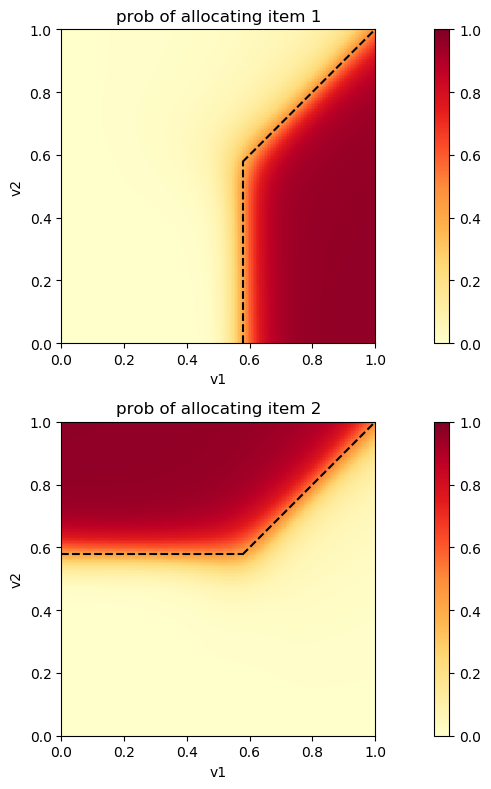

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
cpu_model.sinkhorn_rounds = 20
cpu_model.sinkhorn_epsilon = 5e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

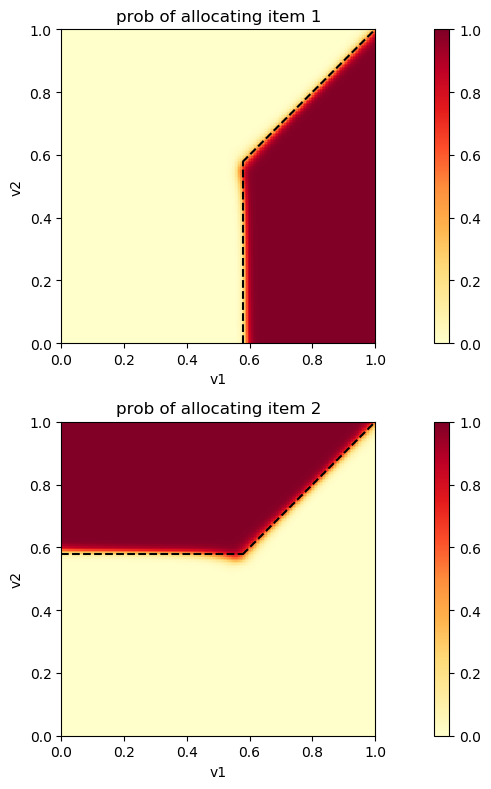

In [15]:
cpu_model.sinkhorn_rounds = 100
cpu_model.sinkhorn_epsilon = 1e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

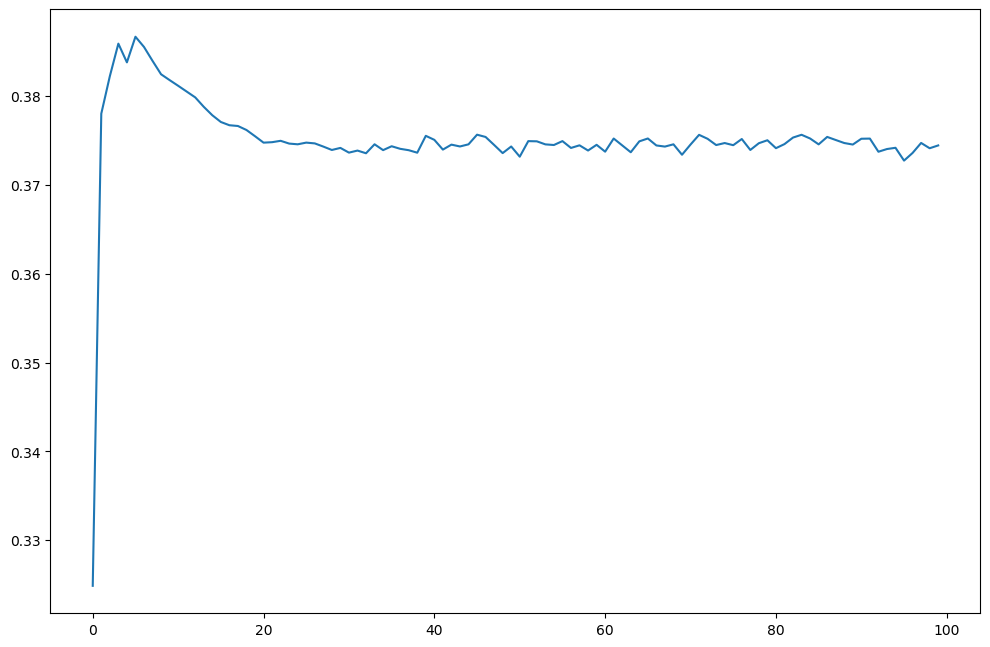

In [16]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [17]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)